In [1]:
# -*- coding: utf-8 -*-

from __future__ import print_function

import time
import warnings
import numpy as np
import time
import matplotlib.pyplot as plt
from numpy import newaxis
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [27]:
''' 处理数据使之符合LSTM的要求 '''

def load_data(filename, seq_len, normalise_window):  # X_train, y_train, X_test, y_test = load_data('sp500.csv', seq_len, True)
    f = open(filename, 'r').read()
    data = f.split('\n')

    print('data len:',len(data))
    print('sequence len:',seq_len)

    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])  #得到长度为seq_len+1的向量，最后一个作为label

    print('result len:',len(result))
    print('result shape:',np.array(result).shape)
    print(result[:1])

    if normalise_window:
        result = normalise_windows(result)

    print(result[:1])
    print('normalise_windows result shape:',np.array(result).shape)

    result = np.array(result)

    #划分train、test
    row = round(0.9 * result.shape[0])  #四舍五入
    train = result[:row, :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[row:, :-1]
    y_test = result[row:, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    return [x_train, y_train, x_test, y_test]

def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:   #window shape (sequence_length L ,)  即(51L,)
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

def build_model(layers):  #layers ： [1,50,100,1]
    model = Sequential()

    model.add(LSTM(input_dim=layers[0],output_dim=layers[1],return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(layers[2],return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print("Compilation Time : ", time.time() - start)
    return model

In [28]:
#直接全部预测
def predict_point_by_point(model, data):
    predicted = model.predict(data)
    print('predicted shape:',np.array(predicted).shape)  #(412L,1L)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

#滚动预测
def predict_sequence_full(model, data, window_size):  #data X_test
    curr_frame = data[0]  #(50L,1L)
    predicted = []
    for i in range(len(data)):
        #x = np.array([[[1],[2],[3]], [[4],[5],[6]]])  x.shape (2, 3, 1) x[0,0] = array([1])  x[:,np.newaxis,:,:].shape  (2, 1, 3, 1)
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])  #np.array(curr_frame[newaxis,:,:]).shape (1L,50L,1L)
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)   #numpy.insert(arr, obj, values, axis=None)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):  #window_size = seq_len
    prediction_seqs = []
    for i in range(len(data)/prediction_len):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

def plot_results(predicted_data, true_data, filename):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()
    plt.savefig(filename+'.png')

def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()
    plt.savefig('plot_results_multiple.png')


In [31]:
if __name__=='__main__':
    global_start_time = time.time()
    epochs  = 1
    seq_len = 50

    print('> Loading data... ')

    X_train, y_train, X_test, y_test = load_data('sp500.csv', seq_len, True)

    print('X_train shape:',X_train.shape)  #(3709L, 50L, 1L)
    print('y_train shape:',y_train.shape)  #(3709L,)
    print('X_test shape:',X_test.shape)    #(412L, 50L, 1L)
    print('y_test shape:',y_test.shape)    #(412L,)

    print('> Data Loaded. Compiling...')

    model = build_model([1, 50, 100, 1])

    model.fit(X_train,y_train,batch_size=512,nb_epoch=epochs,validation_split=0.05)

> Loading data... 
data len: 4172
sequence len: 50
result len: 4121
result shape: (4121, 51)
[['1455.219971', '1399.420044', '1402.109985', '1403.449951', '1441.469971', '1457.599976', '1438.560059', '1432.25', '1449.680054', '1465.150024', '1455.140015', '1455.900024', '1445.569946', '1441.359985', '1401.530029', '1410.030029', '1404.089966', '1398.560059', '1360.160034', '1394.459961', '1409.280029', '1409.119995', '1424.969971', '1424.369995', '1424.23999', '1441.719971', '1411.709961', '1416.829956', '1387.119995', '1389.939941', '1402.050049', '1387.670044', '1388.26001', '1346.089966', '1352.170044', '1360.689941', '1353.430054', '1333.359985', '1348.050049', '1366.420044', '1379.189941', '1381.76001', '1409.170044', '1391.280029', '1355.619995', '1366.699951', '1401.689941', '1395.069946', '1383.619995', '1359.150024', '1392.140015']]
[[0.0, -0.03834466823710192, -0.03649619099406931, -0.03557539137153576, -0.009448743333663301, 0.001635495009297161, -0.011448380541775882, -0.01

predicted shape: (412, 1)
point_by_point_predictions shape: (412,)
Training duration (s) :  57.46721887588501


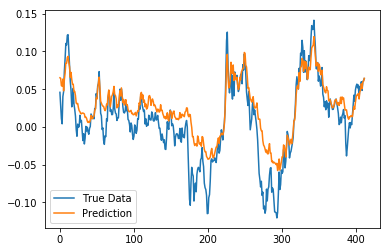

In [33]:
#    multiple_predictions = predict_sequences_multiple(model, X_test, seq_len, prediction_len=50)
#    print('multiple_predictions shape:',np.array(multiple_predictions).shape)   #(8L,50L)

#full_predictions = predict_sequence_full(model, X_test, seq_len)
#print('full_predictions shape:',np.array(full_predictions).shape)    #(412L,)

point_by_point_predictions = predict_point_by_point(model, X_test)
print('point_by_point_predictions shape:',np.array(point_by_point_predictions).shape)  #(412L)

print('Training duration (s) : ', time.time() - global_start_time)

#    plot_results_multiple(multiple_predictions, y_test, 50)
#    plot_results(full_predictions,y_test,'full_predictions')
plot_results(point_by_point_predictions,y_test,'point_by_point_predictions')

In [35]:
'''上面就是博客里面的全部内容，下面是我的测试与验证 '''

point_by_point_predictions.shape

(412,)

In [ ]:
if __name__=='__main__':
    global_start_time = time.time()
    epochs  = 1
    seq_len = 50

    print('> Loading data... ')

    X_train, y_train, X_test, y_test = load_data('sp500.csv', seq_len, True)

    print('X_train shape:',X_train.shape)  #(3709L, 50L, 1L)
    print('y_train shape:',y_train.shape)  #(3709L,)
    print('X_test shape:',X_test.shape)    #(412L, 50L, 1L)
    print('y_test shape:',y_test.shape)    #(412L,)

    print('> Data Loaded. Compiling...')

    model = build_model([1, 50, 100, 1])

    model.fit(X_train,y_train,batch_size=512,nb_epoch=epochs,validation_split=0.05)

    multiple_predictions = predict_sequences_multiple(model, X_test, seq_len, prediction_len=50)
    print('multiple_predictions shape:',np.array(multiple_predictions).shape)   #(8L,50L)

    full_predictions = predict_sequence_full(model, X_test, seq_len)
    print('full_predictions shape:',np.array(full_predictions).shape)    #(412L,)

    point_by_point_predictions = predict_point_by_point(model, X_test)
    print('point_by_point_predictions shape:',np.array(point_by_point_predictions).shape)  #(412L)

    print('Training duration (s) : ', time.time() - global_start_time)

    plot_results_multiple(multiple_predictions, y_test, 50)
    plot_results(full_predictions,y_test,'full_predictions')
    plot_results(point_by_point_predictions,y_test,'point_by_point_predictions')

In [12]:
''' temp '''
seq_len = 50
normalise_window = True

f = open('sp500.csv', 'r').read()
data = f.split('\n')

print('data len:',len(data))
print('sequence len:',seq_len)

sequence_length = seq_len + 1
result = []
for index in range(len(data) - sequence_length):
    result.append(data[index: index + sequence_length])  
# 得到长度为seq_len+1的向量，最后一个作为label
'''
[0,....,0+51]
[1,....,1+51]
[2,....,2+51]
...
...
'''
def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:   #window shape (sequence_length L ,)  即(51L,)
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

if normalise_window:
    result = normalise_windows(result)
print(result[:1])
print('normalise_windows result shape:',np.array(result).shape)
result = np.array(result)

data len: 4172
sequence len: 50
[[0.0, -0.03834466823710192, -0.03649619099406931, -0.03557539137153576, -0.009448743333663301, 0.001635495009297161, -0.011448380541775882, -0.01578453529895929, -0.003806927550748962, 0.006823747060848984, -5.494427068997165e-05, 0.0004673197272937468, -0.006631317046431495, -0.009524323659793943, -0.03689472593143783, -0.031053684597900588, -0.035135585010467096, -0.03893563387606924, -0.0653234142565241, -0.04175314468660485, -0.03156907059791858, -0.03167904297542101, -0.02078723533405935, -0.021199527641721727, -0.0212888646509648, -0.00927694800032397, -0.029899266686190917, -0.026380901695308046, -0.04679703230928234, -0.044859218057006656, -0.03653737789446543, -0.046419048904050575, -0.046013635281535015, -0.07499210234519249, -0.07081398623823587, -0.06495927205770868, -0.06994813088639229, -0.08373990766238593, -0.07364516989576142, -0.06102165223789391, -0.05224641739059799, -0.050480313948357725, -0.03164465023686791, -0.043938334598350504,